# Iris Classification with PyTorch and Cloudera AI Inference

This notebook demonstrates a complete machine learning pipeline:
1. **Model Training**: Train an iris classifier using PyTorch with MLflow tracking
2. **Model Export**: Convert PyTorch model to ONNX format for deployment
3. **Batch Inference**: Run inference against deployed models on Cloudera AI Inference

## Prerequisites
- MLflow server running
- Cloudera AI Inference endpoint deployed (for inference section)
- Required Python packages installed

## Part 1: Model Training and Export

In [13]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import mlflow
import mlflow.pytorch
import mlflow.onnx
import numpy as np
import pandas as pd
import onnx
import onnxruntime as ort
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


### Define the Neural Network Architecture

In [14]:
class IrisClassifier(nn.Module):
    def __init__(self, input_size=4, hidden_size=16, num_classes=3):
        super(IrisClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

print("Model architecture defined!")

Model architecture defined!


### Data Preparation

In [15]:
def prepare_data():
    """Load and prepare the iris dataset"""
    iris = load_iris()
    X, y = iris.data, iris.target
    
    print(f"Dataset shape: {X.shape}")
    print(f"Classes: {iris.target_names}")
    print(f"Features: {iris.feature_names}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)
    
    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, scaler, iris

# Prepare the data
X_train, X_test, y_train, y_test, scaler, iris_data = prepare_data()

Dataset shape: (150, 4)
Classes: ['setosa' 'versicolor' 'virginica']
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Visualize the Dataset

<Figure size 1200x800 with 0 Axes>

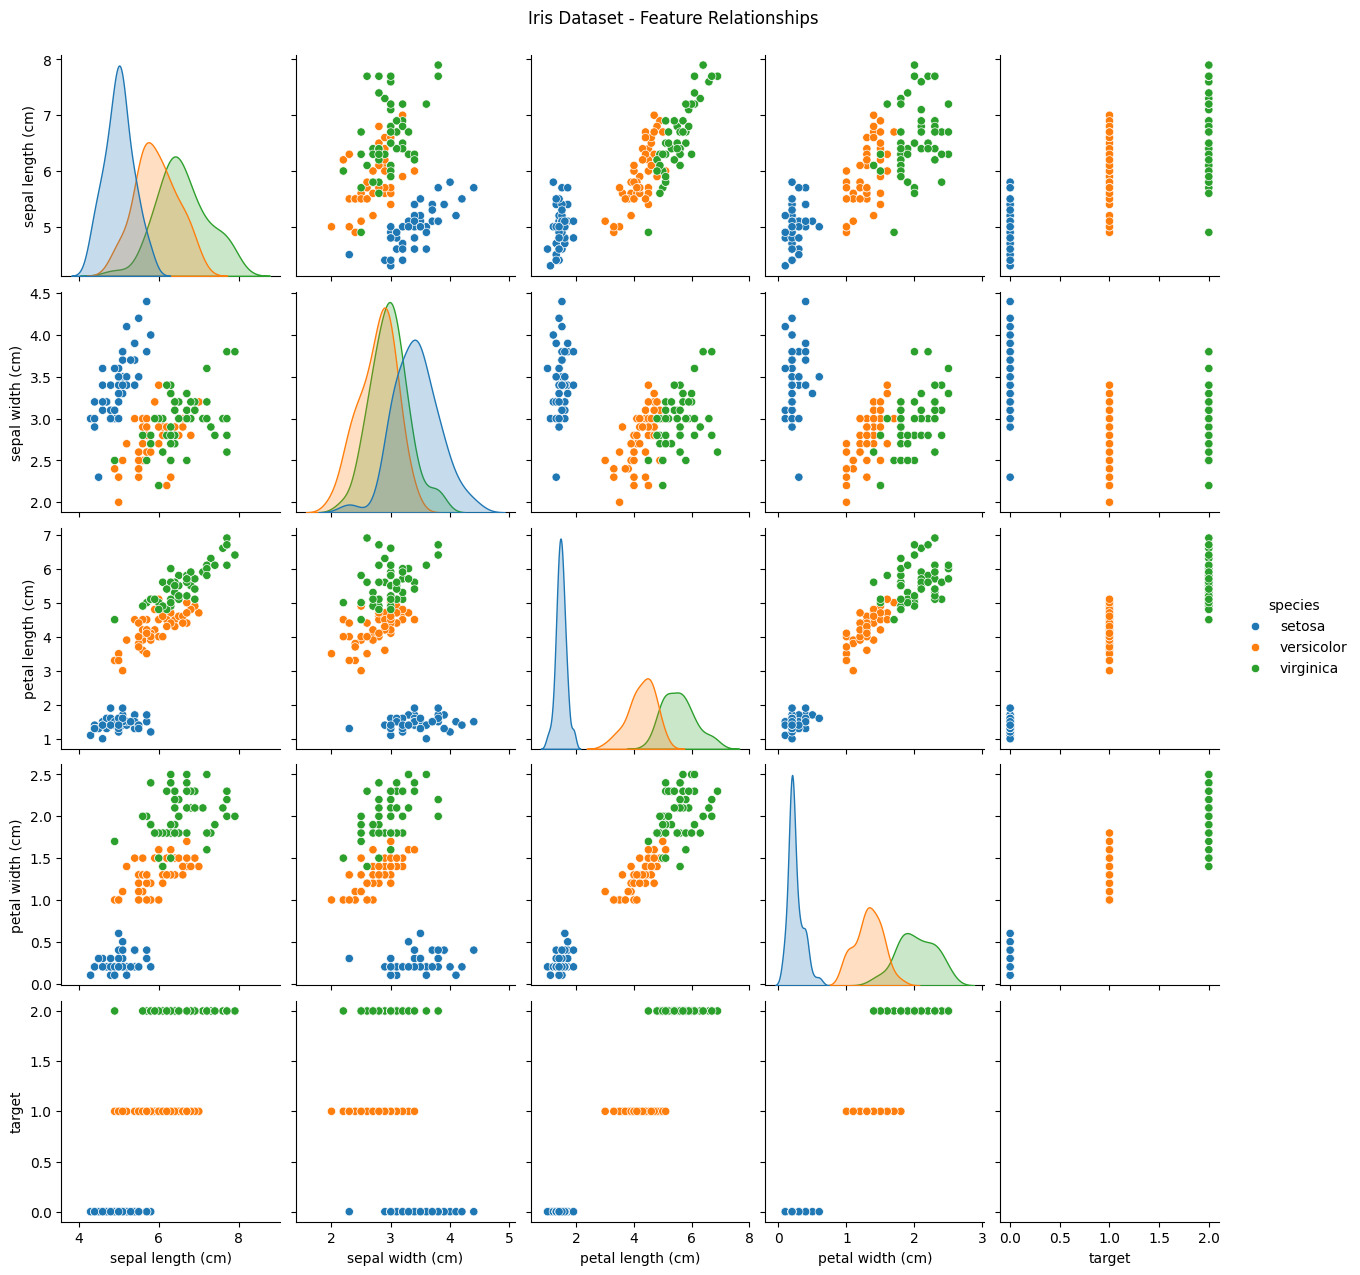

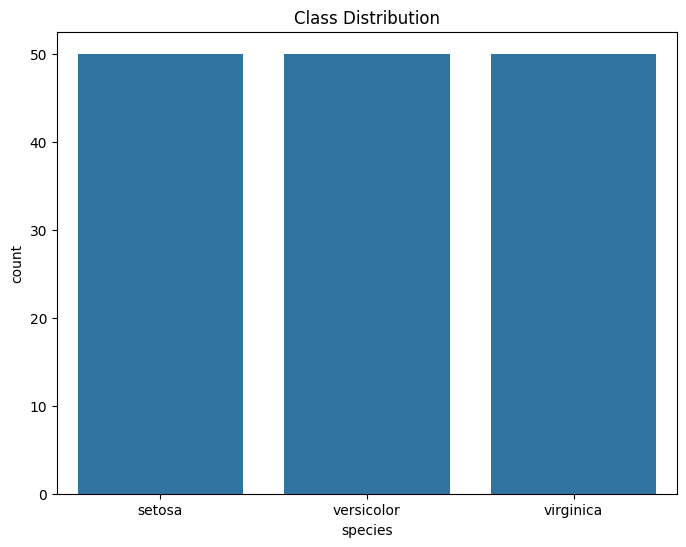

In [16]:
# Create a DataFrame for visualization
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df['target'] = iris_data.target
iris_df['species'] = iris_df['target'].map(dict(enumerate(iris_data.target_names)))

# Create pairplot
plt.figure(figsize=(12, 8))
sns.pairplot(iris_df, hue='species', height=2.5)
plt.suptitle('Iris Dataset - Feature Relationships', y=1.02)
plt.show()

# Class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=iris_df, x='species')
plt.title('Class Distribution')
plt.show()

### Training Functions

In [17]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    """Train the model and return training history"""
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100 * correct / total
        
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return train_losses, train_accuracies

def evaluate_model(model, test_loader):
    """Evaluate the model on test data"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_predictions)
    return accuracy, all_predictions, all_targets

print("Training functions defined!")

Training functions defined!


### Model Training with MLflow Tracking

In [18]:
# Set MLflow experiment
mlflow.set_experiment("iris_classification_notebook")

# Hyperparameters
hidden_size = 16
learning_rate = 0.01
num_epochs = 100
batch_size = 16

print(f"Training configuration:")
print(f"Hidden size: {hidden_size}")
print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Batch size: {batch_size}")

Training configuration:
Hidden size: 16
Learning rate: 0.01
Number of epochs: 100
Batch size: 16


In [19]:
with mlflow.start_run() as run:
    print("Starting MLflow experiment...")
    
    # Log hyperparameters
    mlflow.log_param("hidden_size", hidden_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("batch_size", batch_size)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = IrisClassifier(input_size=4, hidden_size=hidden_size, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print("\nTraining model...")
    # Train the model
    train_losses, train_accuracies = train_model(
        model, train_loader, criterion, optimizer, num_epochs
    )
    
    # Evaluate the model
    print("\nEvaluating model...")
    test_accuracy, predictions, targets = evaluate_model(model, test_loader)
    
    # Log metrics
    mlflow.log_metric("final_train_accuracy", train_accuracies[-1])
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("final_train_loss", train_losses[-1])
    
    # Log training curves
    for epoch, (loss, acc) in enumerate(zip(train_losses, train_accuracies)):
        mlflow.log_metric("train_loss", loss, step=epoch)
        mlflow.log_metric("train_accuracy", acc, step=epoch)
    
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print(f"MLflow Run ID: {run.info.run_id}")
    
    # Store the run_id for later use
    training_run_id = run.info.run_id

Starting MLflow experiment...

Training model...
Epoch [20/100], Loss: 0.1413, Accuracy: 94.17%
Epoch [40/100], Loss: 0.0709, Accuracy: 98.33%
Epoch [60/100], Loss: 0.0446, Accuracy: 98.33%
Epoch [80/100], Loss: 0.0671, Accuracy: 96.67%
Epoch [100/100], Loss: 0.0712, Accuracy: 97.50%

Evaluating model...

Final Test Accuracy: 0.9667
MLflow Run ID: dfxf-omea-aici-paxj


### Visualize Training Progress

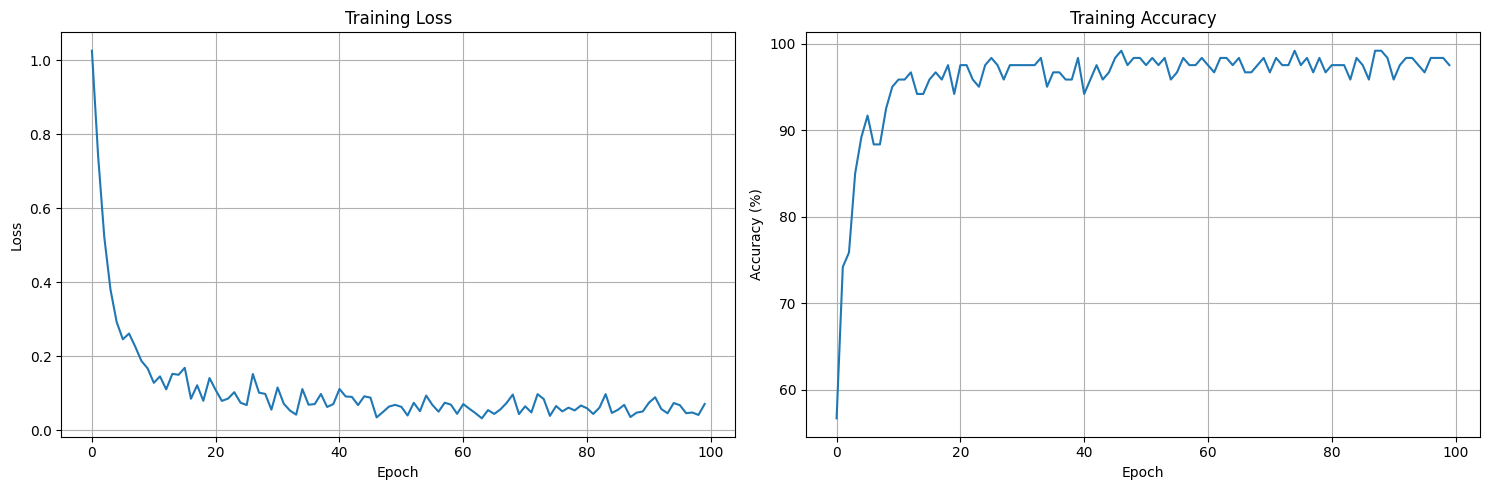

In [20]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Accuracy curve
ax2.plot(train_accuracies)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Model Evaluation and Classification Report

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



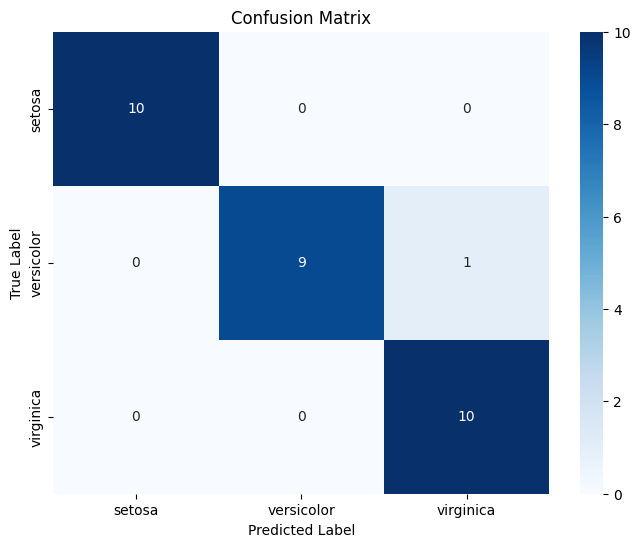

In [21]:
# Create and display classification report
class_names = iris_data.target_names
report = classification_report(targets, predictions, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Convert Model to ONNX Format

In [22]:
def convert_to_onnx(model, input_size=(1, 4), onnx_path="iris_model.onnx"):
    """Convert PyTorch model to ONNX format"""
    model.eval()
    
    # Create dummy input for tracing
    dummy_input = torch.randn(input_size)
    
    # Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    
    print(f"Model exported to ONNX format: {onnx_path}")
    return onnx_path

def verify_onnx_model(onnx_path, test_data):
    """Verify ONNX model works correctly"""
    # Load ONNX model
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)
    
    # Create ONNX Runtime session
    ort_session = ort.InferenceSession(onnx_path)
    
    # Test with a small batch
    test_input = test_data[:5].numpy()  # Take first 5 samples
    ort_inputs = {ort_session.get_inputs()[0].name: test_input}
    ort_outputs = ort_session.run(None, ort_inputs)
    
    print(f"ONNX model verification successful. Output shape: {ort_outputs[0].shape}")
    return True

# Convert and verify ONNX model
onnx_path = "iris_model.onnx"
convert_to_onnx(model, input_size=(1, 4), onnx_path=onnx_path)
verify_onnx_model(onnx_path, X_test)

Model exported to ONNX format: iris_model.onnx
ONNX model verification successful. Output shape: (5, 3)


True

### Log Models to Cloudera AI Registry

In [23]:
# Prepare input examples for model logging
# Use a small sample of test data as input example
input_example = X_test[:3].numpy()  # Convert to numpy array for MLflow
print(f"Input example shape: {input_example.shape}")
print(f"Input example (first sample): {input_example[0]}")

# Optionally, we can also create a model signature manually
import mlflow.types.schema as schema
from mlflow.models.signature import infer_signature

# Create model prediction for signature inference
model.eval()
with torch.no_grad():
    example_output = model(X_test[:3]).numpy()

# Infer signature from input and output
signature = infer_signature(input_example, example_output)
print(f"Model signature: {signature}")
print("✓ Input examples and signature prepared for MLflow logging")

Input example shape: (3, 4)
Input example (first sample): [-1.7215677  -0.10821272 -1.4025038  -1.3232756 ]
Model signature: inputs: 
  [Tensor('float32', (-1, 4))]
outputs: 
  [Tensor('float32', (-1, 3))]
params: 
  None

✓ Input examples and signature prepared for MLflow logging


### Prepare Input Examples for Model Logging

To avoid MLflow warnings, we need to provide input examples when logging models. This helps MLflow automatically infer the model signature.

In [24]:
with mlflow.start_run() as run:
    # Log the PyTorch model to MLflow with input example and signature
    print("Logging PyTorch model to MLflow...")
    mlflow.pytorch.log_model(
        model, 
        "iris_classifier_pytorch",
        registered_model_name="iris_pytorch_classifier_notebook",
        input_example=input_example,
        signature=signature
    )
    
    # Log the ONNX model to MLflow with input example and signature  
    print("Logging ONNX model to MLflow...")
    onnx_model = onnx.load(onnx_path)
    mlflow.onnx.log_model(
        onnx_model,
        "iris_classifier_onnx",
        registered_model_name="iris_onnx_classifier_notebook",
        input_example=input_example,
        signature=signature
    )
    
    print("Models logged successfully to MLflow!")
    print(f"MLflow Run ID: {run.info.run_id}")
    print("✓ Models logged with input examples and signatures - no warnings!")

Logging PyTorch model to MLflow...


2025/06/23 05:10:24 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      -1.7215677499771118,
      -0.10821272432804108,
      -1.4025038480758667,
      -1.3232755661010742
    ],
    [
      0.30848902463912964,
      -0.10821272432804108,
      0.6416313052177429,
      0.7834318280220032
    ],
    [
      -1.1244922876358032,
      -1.4515430927276611,
      -0.26687321066856384,
      -0.2699218988418579
    ]
  ]
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: No module named 'flask'
Successfully registered model 'iris_pytorch_classifier_notebook'.
2025/06/23 05:10:26 INFO

Logging ONNX model to MLflow...


2025/06/23 05:10:32 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      -1.7215677499771118,
      -0.10821272432804108,
      -1.4025038480758667,
      -1.3232755661010742
    ],
    [
      0.30848902463912964,
      -0.10821272432804108,
      0.6416313052177429,
      0.7834318280220032
    ],
    [
      -1.1244922876358032,
      -1.4515430927276611,
      -0.26687321066856384,
      -0.2699218988418579
    ]
  ]
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: No module named 'flask'
Successfully registered model 'iris_onnx_classifier_notebook'.
2025/06/23 05:10:34 INFO ml

Models logged successfully to MLflow!
MLflow Run ID: blby-x6zt-njzk-xdmi
✓ Models logged with input examples and signatures - no warnings!


Created version '2' of model 'iris_onnx_classifier_notebook'.


## Part 2: Deploy Model to Cloudera AI Inference

This section demonstrates how to configure CDP credentials and deploy the trained model from part 1 to Cloudera AI Inference

**Note**: The following steps assume that the cdpcli package is already installed.

In [40]:
# Create CDP configuration
import os
import subprocess
def configure_cdp(varname, value):
    command = ["cdp", "configure", "set", varname, value]
    result = subprocess.run(command, capture_output=True, text=True)

    if result.returncode != 0:
        print("cdp command failed.")
        print("Error:")
        print(result.stderr)
    return None
print("CDP config function defined!")

CDP config function defined!


In [42]:
import getpass

access_key_id = getpass.getpass("Enter your CDP access key ID: ")
private_key = getpass.getpass("Enter your CDP private key: ")
configure_cdp("cdp_access_key_id", access_key_id)
configure_cdp("cdp_private_key", private_key)

Enter your CDP access key ID:  ········
Enter your CDP private key:  ········


## Part 3: Batch Inference (Demo)

**Note**: This section demonstrates the inference client setup. To actually run inference, you need:
1. A deployed model on Cloudera AI Inference
2. Proper authentication credentials
3. Correct endpoint URLs

In [37]:
# Import inference-related libraries
from open_inference.openapi.client import OpenInferenceClient, InferenceRequest
import httpx
import json
import time
from typing import Optional, Dict, Any, List

print("Inference libraries imported (demo mode)")

Inference libraries imported (demo mode)


### Inference Client Class Definition

In [34]:
class TritonBatchInference:
    """Class to handle Triton inference with dynamic batching"""
    
    def __init__(self, base_url: str, model_name: str, token: str):
        self.base_url = base_url
        self.model_name = model_name
        self.headers = {
            'Authorization': f'Bearer {token}',
            'Content-Type': 'application/json'
        }
        # Note: Uncomment these lines for actual inference
        self.httpx_client = httpx.Client(headers=self.headers)
        self.client = OpenInferenceClient(base_url=base_url, httpx_client=self.httpx_client)
        
    def get_triton_model_config(self) -> Optional[Dict[str, Any]]:
        """Get Triton model configuration including dynamic batching settings"""
        config_url = f"{self.base_url}/v2/models/{self.model_name}/config"
        
        try:
            response = self.httpx_client.get(config_url)
            response.raise_for_status()
            config = response.json()
            print("Model Configuration:")
            print(json.dumps(config, indent=2))
            
            # Extract dynamic batching info
            if 'dynamic_batching' in config:
                return config['dynamic_batching']
            else:
                return None
                
        except Exception as e:
            print(f"Error getting model config: {e}")
            return None
    
    def check_server_status(self) -> bool:
        """Check if the server is ready and get model metadata"""
        try:
            # Check server readiness
            self.client.check_server_readiness()
            print("✓ Server is ready")
            
            # Get model metadata
            metadata = self.client.read_model_metadata(self.model_name)
            metadata_dict = json.loads(metadata.json())
            print("Model Metadata:")
            print(json.dumps(metadata_dict, indent=2))
            
            return True
        except Exception as e:
            print(f"Error checking server status: {e}")
            return False
        return True
    
    def prepare_iris_data(self) -> tuple:
        """Load and prepare the iris dataset for inference"""
        # Load iris dataset
        iris = load_iris()
        X, y = iris.data, iris.target
        
        # Split data (we'll use test set for batch inference)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        # Scale the features (assuming model was trained with scaled features)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"Dataset prepared: {len(X_test_scaled)} samples for inference")
        print(f"Feature shape: {X_test_scaled.shape}")
        
        return X_test_scaled, y_test, iris.target_names
    
    def create_batches(self, data: np.ndarray, batch_size: int) -> List[np.ndarray]:
        """Create batches from the input data"""
        batches = []
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            batches.append(batch)
        return batches
    
    def run_batch_inference_demo(self, data: np.ndarray, batch_size: int) -> np.ndarray:
        """Run batch inference on the data"""
        batches = self.create_batches(data, batch_size)
        all_predictions = []
        
        print(f"Running inference on {len(batches)} batches of size {batch_size}")
        
        for i, batch in enumerate(batches):
            try:
                # Create inference request
                # Note: Adjust input/output names based on your model's specification
                inference_request = InferenceRequest(
                    inputs=[{
                        "name": "input",  # Adjust based on your model's input name
                        "shape": list(batch.shape),
                        "datatype": "FP32",
                        "data": batch.flatten().tolist()
                    }],
                )
                
                start_time = time.time()
                response = self.client.model_infer(self.model_name, request=inference_request)
                inference_time = time.time() - start_time
                
                # Extract predictions from response
                response_dict = json.loads(response.json())
                output_data = response_dict['outputs'][0]['data']
                
                # Reshape output to match batch size and number of classes
                output_array = np.array(output_data).reshape(batch.shape[0], -1)
                predictions = np.argmax(output_array, axis=1)
                all_predictions.extend(predictions)
                
                print(f"Batch {i+1}/{len(batches)} completed in {inference_time:.3f}s")
                
            except Exception as e:
                print(f"Error in batch {i+1}: {e}")
                # Fill with dummy predictions to maintain consistency
                dummy_predictions = [0] * len(batch)
                all_predictions.extend(dummy_predictions)
        
        return np.array(all_predictions)
    
    def evaluate_predictions(self, predictions: np.ndarray, y_true: np.ndarray, 
                           class_names: List[str]) -> Dict[str, Any]:
        """Evaluate the predictions and return metrics"""
        accuracy = accuracy_score(y_true, predictions)
        report = classification_report(y_true, predictions, target_names=class_names)
        
        results = {
            'accuracy': accuracy,
            'classification_report': report,
            'total_samples': len(y_true),
            'correct_predictions': np.sum(predictions == y_true)
        }
        
        return results

print("Inference client class defined!")

Inference client class defined!


### Demo Inference Pipeline

In [35]:
# Demo configuration (replace with actual values for real inference)
DEMO_BASE_URL = "https://caii-prod-long-running.eng-ml-l.vnu8-sqze.cloudera.site/namespaces/serving-default/endpoints/iris-onnx"
DEMO_MODEL_NAME = "5p90-wqi7-c5wu-7ira"
DEMO_TOKEN = "eyJraWQiOiIzYzhlNzA3OTEyZmI0NTA1ODE3NzE3YzMyOTU4MmQwMTFjYjlmNTAwIiwidHlwIjoiSldUIiwiYWxnIjoiUlMyNTYifQ.eyJzdWIiOiJ6b3JhbSIsImF1ZCI6Imh0dHBzOi8vZGUudm51OC1zcXplLmNsb3VkZXJhLnNpdGUiLCJpc3MiOiJodHRwczovL2NvbnNvbGVhdXRoLmNkcC5jbG91ZGVyYS5jb20vMTJhMDA3OWItMTU5MS00Y2EwLWI3MjEtYTQ0NmJkYTc0ZTY3IiwiZ3JvdXBzIjoiY2RwX2Nsb3VkZXJhX3dvcmtlcnNfd3cgX2NfZW52X2Fzc2lnbmVlc180ZDU2YWI4NiBfY19pbXBhbGFfYWRtaW5zXzc0OWVlNWQ1IF9jX2VmbV9hZG1pbnNfMmMwZmI5NjggX2NfbWxfdXNlcnNfMmMwZmI5NjggX2NfcmFuZ2VyX2FkbWluc18yYzBmYjk2OCBfY19rbm94X2FkbWluc180ZDU2YWI4NiBfY19jbV9hZG1pbnNfNzQ5ZWU1ZDUgX2NfbmlmaV9hZG1pbnNfNzQ5ZWU1ZDUgX2NfbmlmaV9yZWdpc3RyeV9hZG1pbnNfNzQ5ZWU1ZDUgX2NfZWZtX2FkbWluc183NDllZTVkNSBfY19tbF91c2Vyc183NDllZTVkNSBfY196ZXBwZWxpbl9hZG1pbnNfMmMwZmI5NjggX2NfemVwcGVsaW5fYWRtaW5zXzc0OWVlNWQ1IF9jX3Jhbmdlcl9hZG1pbnNfNzQ5ZWU1ZDUgX2NfbmlmaV9yZWdpc3RyeV9hZG1pbnNfMmMwZmI5NjggX2NfbmlmaV9hZG1pbnNfMmMwZmI5NjggX2NfbmlmaV9yZWdpc3RyeV9hZG1pbnNfNGQ1NmFiODYgX2NfbmlmaV9hZG1pbnNfNGQ1NmFiODYgX2NfbWxfYWRtaW5zXzc0OWVlNWQ1IF9jX2hiYXNlX2FkbWluc183NDllZTVkNSBfY19tbF9hZG1pbnNfNTQ4YTdmOTUgX2NfbWxfdXNlcnNfNGQ1NmFiODYgX2NfZW52X2Fzc2lnbmVlc18yYzBmYjk2OCBfY19oYmFzZV9hZG1pbnNfNGQ1NmFiODYgX2NfZWZtX2FkbWluc180ZDU2YWI4NiBfY19yYW5nZXJfYWRtaW5zXzRkNTZhYjg2IF9jX2tub3hfYWRtaW5zXzJjMGZiOTY4IF9jX3plcHBlbGluX2FkbWluc180ZDU2YWI4NiBfY19lbnZfYXNzaWduZWVzXzc0OWVlNWQ1IF9jX21sX2FkbWluc18yYzBmYjk2OCBfY19tbF9hZG1pbnNfNGQ1NmFiODYgX2Nfa25veF9hZG1pbnNfNzQ5ZWU1ZDUgX2NfaGJhc2VfYWRtaW5zXzJjMGZiOTY4IF9jX2ltcGFsYV9hZG1pbnNfMmMwZmI5NjggX2NfY21fYWRtaW5zXzRkNTZhYjg2IF9jX2NtX2FkbWluc18yYzBmYjk2OCIsImV4cCI6MTc2MDY1NTg1MSwidHlwZSI6InVzZXIiLCJnaXZlbl9uYW1lIjoiWm9yYW0iLCJpYXQiOjE3NTA2NTU4NTEsImZhbWlseV9uYW1lIjoiVGhhbmdhIiwiZW1haWwiOiJ6b3JhbUBjbG91ZGVyYS5jb20ifQ.JDR8HqSZL-MZ1Xnw6hlIXGiuEsBASGeFeCfJnqTD19kgLySsdEhRs5fFFM_s-c55rds06mtvUXG5PGjrsA48EM8MTOWWer_JuyUBlIWDlEn6uz-fIiOlLUXmODrUTYv9M6eQkgOYi2cH9dLxRqmIhXOMsVqZ4c35dlB2ZCqOh1PiW0J28tAmMCPvzoHF7myc7N2L5HglcIN0I81QHKmDb_L9oRgUSFc3jSl9yRmJt1XkKFVtII76da1vsXEjwsx_zFtNBVTZcnQD5YWGjpTbFKg_Bvcya-FQLzom7XAGS2PUcnB_NrOOPmHBtRVhOGc40rLCfIViRB4yRcFeCJlKbQ"

# Initialize demo inference client
demo_client = TritonBatchInference(DEMO_BASE_URL, DEMO_MODEL_NAME, DEMO_TOKEN)

print("Demo inference client initialized")
print(f"Base URL: {DEMO_BASE_URL}")
print(f"Model Name: {DEMO_MODEL_NAME}")

Demo inference client initialized
Base URL: https://caii-prod-long-running.eng-ml-l.vnu8-sqze.cloudera.site/namespaces/serving-default/endpoints/iris-onnx
Model Name: 5p90-wqi7-c5wu-7ira


In [36]:
# Run demo inference pipeline
print("=" * 50)
print("DEMO BATCH INFERENCE PIPELINE")
print("=" * 50)

# Check server status (demo)
if demo_client.check_server_status():
    print("✓ Demo server ready")

# Get model configuration (demo)
config = demo_client.get_triton_model_config()
batch_size = config['preferred_batch_size'][0] if config else 8
print(f"Using batch size: {batch_size}")

# Prepare data
X_inference, y_inference, class_names = demo_client.prepare_iris_data()

# Run demo inference
print("\nRunning demo batch inference...")
start_time = time.time()
demo_predictions = demo_client.run_batch_inference_demo(X_inference, batch_size)
total_time = time.time() - start_time

# Evaluate demo results
results = demo_client.evaluate_predictions(demo_predictions, y_inference, class_names)
results['total_inference_time'] = total_time
results['avg_time_per_sample'] = total_time / len(X_inference)
results['throughput_samples_per_second'] = len(X_inference) / total_time

print("\n" + "=" * 50)
print("DEMO INFERENCE RESULTS")
print("=" * 50)
print(f"Total Samples: {results['total_samples']}")
print(f"Correct Predictions: {results['correct_predictions']}")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Total Inference Time: {results['total_inference_time']:.3f}s")
print(f"Average Time per Sample: {results['avg_time_per_sample']:.6f}s")
print(f"Throughput: {results['throughput_samples_per_second']:.2f} samples/second")

print("\nDemo Classification Report:")
print(results['classification_report'])

DEMO BATCH INFERENCE PIPELINE
✓ Server is ready
Model Metadata:
{
  "name": "5p90-wqi7-c5wu-7ira",
  "versions": [
    "1"
  ],
  "platform": "onnxruntime_onnx",
  "inputs": [
    {
      "name": "input",
      "datatype": "FP32",
      "shape": [
        -1,
        4
      ]
    }
  ],
  "outputs": [
    {
      "name": "output",
      "datatype": "FP32",
      "shape": [
        -1,
        3
      ]
    }
  ]
}
✓ Demo server ready
Model Configuration:
{
  "name": "5p90-wqi7-c5wu-7ira",
  "platform": "onnxruntime_onnx",
  "backend": "onnxruntime",
  "runtime": "",
  "version_policy": {
    "latest": {
      "num_versions": 1
    }
  },
  "max_batch_size": 4,
  "input": [
    {
      "name": "input",
      "data_type": "TYPE_FP32",
      "format": "FORMAT_NONE",
      "dims": [
        4
      ],
      "is_shape_tensor": false,
      "allow_ragged_batch": false,
      "optional": false,
      "is_non_linear_format_io": false
    }
  ],
  "output": [
    {
      "name": "output",
    

### Real Inference Setup Instructions

To run actual inference against a deployed model:

1. **Deploy your ONNX model** to Cloudera AI Inference
2. **Update configuration variables**:
   ```python
   BASE_URL = 'https://your-actual-endpoint.com'
   MODEL_NAME = 'your-actual-model-name'
   ```
3. **Set up authentication**:
   ```python
   # Option 1: Token file
   def load_token(token_path="/tmp/jwt"):
       with open(token_path, 'r') as f:
           token_data = json.load(f)
           return token_data["access_token"]
   
   # Option 2: Environment variable
   import os
   token = os.getenv('CDP_TOKEN')
   ```
4. **Install required packages**:
   ```bash
   pip install open-inference httpx
   ```
5. **Replace demo client with real client**:
   ```python
   # Uncomment the httpx and OpenInferenceClient imports
   # Initialize real client instead of demo
   ```

## Summary

This notebook demonstrated:

1. **Complete ML Pipeline**: From data loading to model deployment
2. **PyTorch Model Training**: Neural network with proper validation
3. **MLflow Integration**: Experiment tracking and model registry
4. **ONNX Conversion**: Model format conversion for deployment
5. **Inference Client**: Framework for batch inference against deployed models

### Next Steps:
- Deploy the ONNX model to Cloudera AI Inference
- Configure real authentication and endpoint URLs
- Run production batch inference
- Monitor model performance and retrain as needed

In [ ]:
# Clean up temporary files
import os

files_to_clean = ["iris_model.onnx"]
for file_path in files_to_clean:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Cleaned up: {file_path}")

print("Notebook execution completed!")